This notebook contains code used in part 1 of British Airways data analysis job simulation on Forage. 
Libraries utilized: requests, re, BeautifulSoup, pandas, nltk, wordcloud

In [1]:
#!/.venv/bin/python3

import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS

/var/folders/4q/3hpsmm7139xd1jt2kz8jxjrc0000gn/T/ipykernel_29715/3703697953.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Grab review content

base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 100

reviews = []

for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())
    
    print(f"   ---> {len(reviews)} total reviews")

Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 500 total reviews
Scraping page 6
   ---> 600 total reviews
Scraping page 7
   ---> 700 total reviews
Scraping page 8
   ---> 800 total reviews
Scraping page 9
   ---> 900 total reviews
Scraping page 10
   ---> 1000 total reviews


In [4]:
# Store in a dataframe and save to disk
df = pd.DataFrame()
df["reviews"] = reviews

df.to_csv("data/BA_reviews.csv")

df.head()

,reviews
0,✅ Trip Verified | Have no fear when your BA f...
1,Not Verified | We have flown BA five times fr...
2,✅ Trip Verified | London Heathrow to Istanbul...
3,"Not Verified | Jan 30th, I booked a last-minut..."
4,✅ Trip Verified | I am a British Airways Gold ...


In [5]:
# Clean review strings of verified / not verified prefix

raw_df = pd.read_csv("data/BA_reviews.csv")
clean_df = pd.DataFrame()
cleaned_list = []

for raw_review in raw_df.reviews:
    cleaned_list.append(raw_review[raw_review.index('|')+1:])

clean_df['reviews'] = cleaned_list
display(clean_df)

full_text = "".join(review for review in clean_df['reviews'])

,reviews
0,Have no fear when your BA flight is operated...
1,We have flown BA five times from western USA...
2,London Heathrow to Istanbul at the start of ...
3,"Jan 30th, I booked a last-minute, transatlant..."
4,I am a British Airways Gold Guest List member...
...,...
995,Gatwick to St Lucia return. Recently returne...
996,It's been many years since I flew long haul ...
997,\r\nLondon Heathrow / Pisa return. My wife an...
998,Edinburgh to Boston via London. The planes ar...


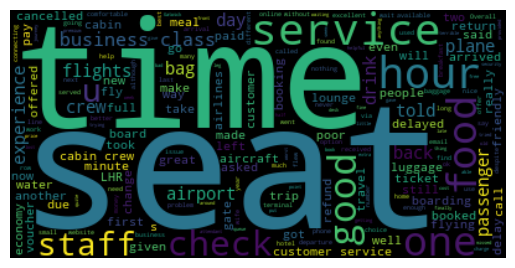

In [6]:
# Reviews are now ready for basic analysis. First we perform a wordcloud to identify review topics of interest, 
# then we will run sentiment analysis

# Remove stopwords which are likely to be very common in reviews but not particularly enlightening 
wc_stopwords = set(STOPWORDS)
wc_stopwords.update(["ba", "flight", "british", "airway", "london", "airways", "airline", "heathrow"]) # "seat", "seats", "hour"

# Generate wordcloud
cloud = WordCloud(stopwords=wc_stopwords).generate(full_text)
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [7]:
# Download nltk models
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /Users/securedhummer/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /Users/securedhummer/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /Users/securedhummer/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /Users/securedhummer/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /Users/securedhummer/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[

True

In [8]:
# Initialize sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Helper method, used below
def preprocess_text(text):
    """Tokenizes and lemmatized text passed"""

    tokens = word_tokenize(text.lower())
    filtered_tokens = [token for token in tokens if token not in nltk.corpus.stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    processed_text = ' '.join(lemmatized_tokens)
    return processed_text

# Helper method, used below
def get_sentiment(text):
    """Get compound sentiment, classify as either 1 (positive) or 0 (negative)"""

    scores = analyzer.polarity_scores(text)

    sentiment = 1 if scores['compound'] > 0 else 0
    return sentiment

In [9]:
# Preprocess and analyze reviews
clean_df['pp_reviews'] = clean_df['reviews'].apply(preprocess_text)
clean_df['sentiment'] = clean_df['pp_reviews'].apply(get_sentiment) 
display(clean_df)

# Save to analyzed copy disk
clean_df.to_csv("data/BA_reviews_w_compound.csv")

,reviews,pp_reviews,sentiment
0,Have no fear when your BA flight is operated...,fear ba flight operated finnair . business cla...,1
1,We have flown BA five times from western USA...,flown ba five time western usa england . alway...,0
2,London Heathrow to Istanbul at the start of ...,london heathrow istanbul start half-term schoo...,1
3,"Jan 30th, I booked a last-minute, transatlant...","jan 30th , booked last-minute , transatlantic ...",0
4,I am a British Airways Gold Guest List member...,british airway gold guest list member ( lifeti...,1
...,...,...,...
995,Gatwick to St Lucia return. Recently returne...,gatwick st lucia return . recently returned tw...,0
996,It's been many years since I flew long haul ...,'s many year since flew long haul british airw...,1
997,\r\nLondon Heathrow / Pisa return. My wife an...,london heathrow / pisa return . wife fly route...,1
998,Edinburgh to Boston via London. The planes ar...,edinburgh boston via london . plane ancient ne...,0


In [10]:
# Output positive and negative totals
print('{} / 1000 reviews were deemed positive\n{} / 1000 thus were deemed negative'.format(clean_df['sentiment'].sum(), 1000 - clean_df['sentiment'].sum()))

570 / 1000 reviews were deemed positive
430 / 1000 thus were deemed negative


In [11]:
# Further sentiment analysis on keywords identified by wordcloud
wc_keywords = ['service', 'time', 'food', 'seat', 'staff', 'crew', 'return', 'experience', 'luggage', 'cabin', 'hour']
kw_counts = {}

# initialize counts and scores to 0
for keyword in wc_keywords:
    kw_counts[keyword] = { 'count' : 0, 'sum': 0 }

# Look for key words and record score of relevant reviews
for index, row in clean_df.iterrows():

    # Identify reviews with keywords in them
    for keyword in wc_keywords:
        if keyword in row['reviews']:
            kw_counts[keyword]['count'] += 1
            kw_counts[keyword]['sum'] += row['sentiment']

for kw_topic, values in kw_counts.items():
    print('{} score: {}/{}: {:.2%}'.format(kw_topic, values['sum'], values['count'], values['sum'] / values['count']))

service score: 281/467: 60.17%
time score: 275/438: 62.79%
food score: 187/277: 67.51%
seat score: 264/415: 63.61%
staff score: 158/250: 63.20%
crew score: 215/294: 73.13%
return score: 89/160: 55.62%
experience score: 119/213: 55.87%
luggage score: 69/125: 55.20%
cabin score: 159/227: 70.04%
hour score: 181/378: 47.88%


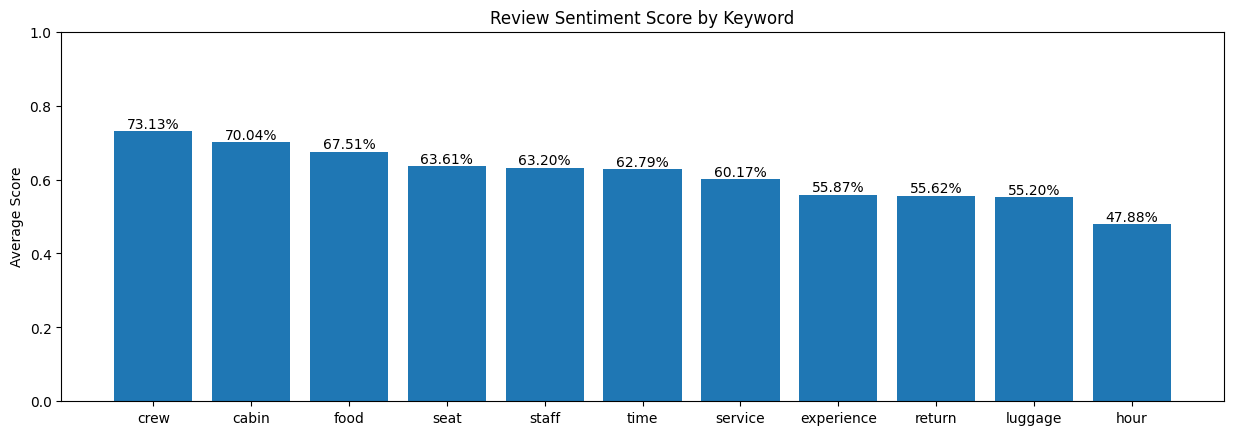

In [12]:
# Plot keyword sentiments

sorted_by_sent = dict(sorted(kw_counts.items(), key = lambda item: item[1]['sum'] / item[1]['count'], reverse = True))

fig, ax = plt.subplots()
fig.set_figwidth(15)
bar_container = ax.bar(sorted_by_sent.keys(), [x['sum'] / x['count'] for index, x in sorted_by_sent.items()])
ax.set(ylabel='Average Score', title='Review Sentiment Score by Keyword', ylim=(0, 1))
ax.bar_label(bar_container, fmt='{:.2%}')

plt.show()